In the previous post, we talked about using KD-tree to find the cloest points from a reference point in a group. But we notice that, it is using the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance). In reality, we use the points on the earth, and want to use the real distance between two points on the earth (at least for me, this is usually the case). Therefore, we need to use the KD-tree with the real distances we usually used in life. In this post, I will tell you how to do it. 

In [1]:
from scipy import spatial
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
%matplotlib inline

plt.style.use('seaborn-poster')

Let's first generate a grid of data points in Bay Area with latitude/longitude step 0.1 degree. We can choose the reference point at the center of the map. See the following figure:

In [2]:
# define map ranges
llat = 37.0
ulat = 38.5
llon = -123
ulon = -121.5

# generate grid points
lats = np.arange(llat, ulat, 0.1)
lons = np.arange(llon, ulon, 0.1)
lons, lats = np.meshgrid(lons, lats)

# flatten the locations
lons_1d = lons.flatten()
lats_1d = lats.flatten()

# reference point as the center of the map
lat_0 = (llat + ulat) / 2.
lon_0 = (llon + ulon) / 2.

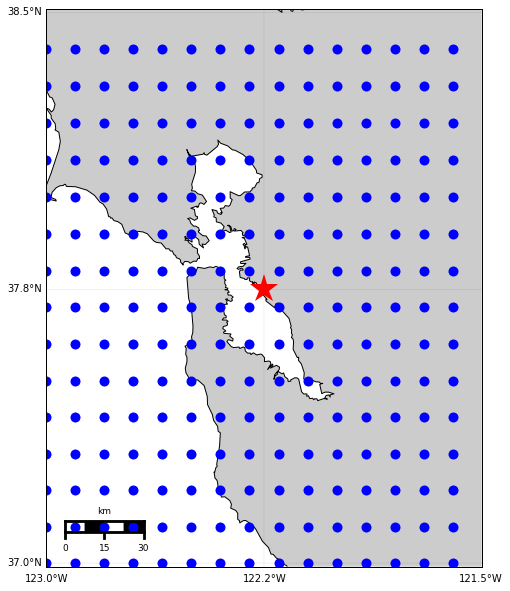

In [3]:
plt.figure(figsize=(10,10))
m = Basemap(projection='merc', lon_0=-125.36929, lat_0=38.3215, 
        llcrnrlon=llon,llcrnrlat=llat- 0.01,urcrnrlon=ulon,urcrnrlat=ulat + 0.01,resolution='h')
m.drawcoastlines()
m.drawmapboundary()

m.drawparallels(np.arange(llat, ulat + 0.01, (ulat - llat)/2.), labels=[1,0,0,0], linewidth=0.1, fmt='%.1f')
m.drawmeridians(np.arange(llon, ulon + 0.01, (ulon - llon)/2.), labels=[0,0,0,1], linewidth=0.1, fmt='%.1f') 

x_0, y_0 = m(lons_1d, lats_1d)
m.plot(x_0, y_0, 'bo', markersize=10) 

x_0, y_0 = m(lon_0, lat_0)
m.plot(x_0, y_0, 'r*', markersize=30) 

m.fillcontinents()
m.drawmapscale(llon + 0.2, llat + 0.1, lon_0, lat_0, 30, 'fancy')

plt.show()

## Find the points within 30 km from the reference point

Now, let's find the points within 30 km from the reference points using KD-tree. I got the idea from [this discussion at stackoverflow](https://stackoverflow.com/questions/43020919/scipy-how-to-convert-kd-tree-distance-from-query-to-kilometers-python-pandas). The basic idea is to convert the latidue and longitude of the points to 3D catesian coordinates, and do the KD-tree query in this catesian coordinates. We first define the functions to convert the points between the geo-coordinates and the catesian coordinates. 

In [4]:
from math import *

def to_Cartesian(lat, lng):
    '''
    function to convert latitude and longitude to 3D catesian coordinates
    '''
    R = 6371 # radius of the Earth in kilometers

    x = R * cos(lat) * cos(lng)
    y = R * cos(lat) * sin(lng)
    z = R * sin(lat)
    return x, y, z

def deg2rad(degree):
    '''
    function to convert degree to radian
    '''
    rad = degree * 2*np.pi / 360
    return(rad)

def rad2deg(rad):
    '''
    function to convert radian to degree
    '''
    degree = rad/2/np.pi * 360
    return(degree)

def distToKM(x):
    '''
    function to convert catesian distance to real distance in km
    '''
    R = 6371 # earth radius
    gamma = 2*np.arcsin(deg2rad(x/(2*R))) # compute the angle of the isosceles triangle
    dist = 2*R*sin(gamma/2) # compute the side of the triangle
    return(dist)

def kmToDIST(x):
    '''
    function to convert real distance in km to catesian distance 
    '''
    R = 6371 # earth radius
    gamma = 2*np.arcsin(x/2./R) 
    
    dist = 2*R*rad2deg(sin(gamma / 2.))
    return(dist)

In [5]:
# convert the grid points and reference points to catesian coordinates
x, y, z = zip(*map(to_Cartesian, lats_1d, lons_1d))
x_ref, y_ref, z_ref = to_Cartesian(lat_0, lon_0)

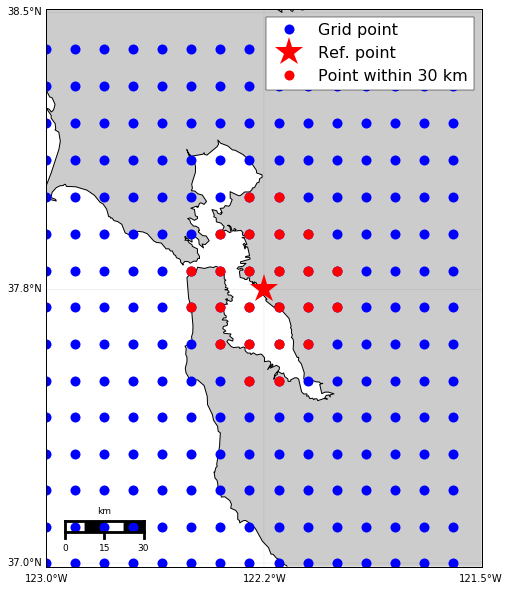

In [7]:
# convert the 30 km to catesian coordinates distance
dist = kmToDIST(30)

# create the KD-tree using the 3D catesian coordinates
coordinates = list(zip(x, y, z))
tree = spatial.cKDTree(coordinates)

# get all the points within 30 km from the reference point
ix = tree.query_ball_point((x_ref, y_ref, z_ref), dist)

# plot them on the map
plt.figure(figsize=(10,10))
m = Basemap(projection='merc', lon_0=-125.36929, lat_0=38.3215, 
        llcrnrlon=llon,llcrnrlat=llat- 0.01,urcrnrlon=ulon,urcrnrlat=ulat + 0.01,resolution='h')
m.drawcoastlines()
m.drawmapboundary()

m.drawparallels(np.arange(llat, ulat + 0.01, (ulat - llat)/2.), labels=[1,0,0,0], linewidth=0.1, fmt='%.1f')
m.drawmeridians(np.arange(llon, ulon + 0.01, (ulon - llon)/2.), labels=[0,0,0,1], linewidth=0.1, fmt='%.1f') 

x_0, y_0 = m(lons_1d, lats_1d)
m.plot(x_0, y_0, 'bo', markersize=10, label = 'Grid point') 

x_0, y_0 = m(lon_0, lat_0)
m.plot(x_0, y_0, 'r*', markersize=30, label = 'Ref. point') 

x_0, y_0 = m(lons_1d[ix], lats_1d[ix])
m.plot(x_0, y_0, 'ro', markersize=10, label = 'Point within 30 km') 

m.fillcontinents()
m.drawmapscale(llon + 0.2, llat + 0.1, lon_0, lat_0, 30, 'fancy')

plt.legend(numpoints = 1)

plt.show()

## Find the distances for the closest 10 points

We can also find the distances from the closest 10 points. This will be very simple by using the query function. 

In [8]:
# get the catesian distances from the 10 closest points
dist, ix = tree.query((x_ref, y_ref, z_ref), 10)

# print out the real distances in km
print(map(distToKM, dist))

[7.849314101994533, 7.849314102001198, 7.859304141667372, 7.859304141674064, 17.516008198378657, 17.516008198387585, 17.547633149227252, 17.547633149230194, 17.55621138531865, 17.556211385327607]
